In [1]:
import os
import pyboard
import time
import json
import numpy as np
from pylab import *

pb = None

In [2]:
## find out the port that connects to SPM 32
result = os.popen('ls -l /dev/ttyUSB*').read()
result = result.strip('\n').split(' ')
port = result[-1]
print(port)

/dev/ttyUSB0


In [3]:
pb = None
try:
    pb = pyboard.Pyboard(port)
    pb.enter_raw_repl()  
except pyboard.PyboardError as e:
    print(e) 

In [4]:
def run_on_board(code, wait_s=0, no_print=False):
    for ln in code:
        res = pb.exec(ln)
        if len(res) > 0 and not no_print:
            res = res[:-2].decode()
            print(res)
    if wait_s > 0:
        time.sleep(wait_s)        
    return res    

## set up the C12880MA

In [6]:
script = [
    'from driver.c12880ma import C12880MA',
    'import board',
    'sp = C12880MA(trg=board.TRG, st=board.STA, clk=board.CLK, video=board.VID)',
    'sp.begin()',
    'sp.setIntegrationTime_s(0.2)',
    'print(list(sp.wavelengths))'
]
nm = json.loads(run_on_board(script, wait_s=0.4, no_print=True))

In [32]:
script = ['sp._measureMinIntegTime()',
          'print(sp._min_integ_us)']
min_integ_us = json.loads(run_on_board(script, no_print=True))
print(min_integ_us)

2484


In [38]:
def get_spectrum(int_t_s):
    script = [
        'sp.setIntegrationTime_s({})'.format(int_t_s),
        'sp.read()',
        'print(list(sp.spectrum))'
    ]
    raw = json.loads(run_on_board(script, no_print=True))
    return raw

(0.0, 4095.0)

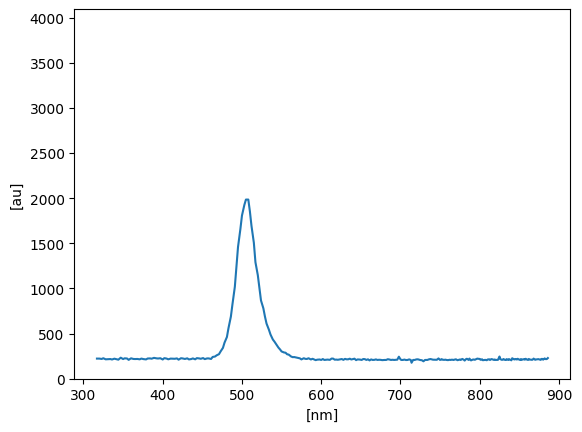

In [53]:
data = get_spectrum(0.05)
plot(nm, data)
ylabel("[au]")
xlabel("[nm]")
ylim(0,4095)

In [64]:
blue_490nm_50ms=[]
for ii in range(10):
    blue_490nm_50ms.append(get_spectrum(0.05))
    time.sleep(2)
blue_490nm_50ms=np.asarray(blue_490nm_50ms)
mean_blue_490nm_50ms=np.mean(blue_490nm_50ms,axis=0)

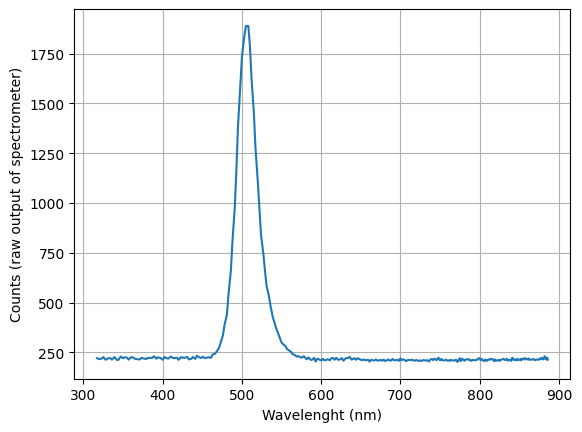

In [65]:
plt.plot(nm,mean_blue_490nm_50ms)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")
plt.grid()

## turn off the LED

In [ ]:
#get dark noise
dark_50ms=[]
for ii in range(10):
    dark_50ms.append(get_spectrum(0.05))
    time.sleep(2)
dark_50ms=np.asarray(dark_50ms)
mean_dark_50ms=np.mean(dark_50ms,axis=0)
plt.plot(nm,mean_dark_50ms)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")
plt.grid()

## final result

In [ ]:
## blue 490nm 50ms exclude dark noise
blue_490nm_50ms_pure=mean_blue_490nm_50ms-mean_dark_50ms
plt.plot(nm,blue_490nm_50ms_pure)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")
plt.grid()
plt.title('490_nm_telescope_no_dark_noise')

In [61]:
print(nm[np.argmax(blue_490nm_50ms_pure)])

505.0
